## Project Details

Module Name: CT5228
Assignmet 3: BER Homes Analysis
Name: Michael Lynagh
ID: 23202058
Year 1 - Autumn Semester
Date: 14/12/2025

In [88]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import sys
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, davies_bouldin_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler



In [89]:
# Step 1 - Import Data 
df = pd.read_csv('BER_Train.csv', encoding='utf-8')
df.head()

,CountyName,DwellingTypeDescr,Year_of_Construction,EnergyRating,GroundFloorArea(sq m),UValueWall,UValueRoof,UValueFloor,UValueWindow,UvalueDoor,...,WaterStorageVolume,DeclaredLossFactor,TempFactorUnadj,TempFactorMultiplier,GroundFloorArea,GroundFloorHeight,FirstFloorArea,FirstFloorHeight,GlazingPercent,Volume
0,Co. Wexford,Detached house,2004,D2,103.44,0.55,0.26,0.47,1.9,3.0,...,98.0,0.00,0.6,1.3,51.72,2.46,51.72,2.73,0.114906,536.8536
1,Co. Dublin,Semi-detached house,2017,A3,115.96,0.21,0.12,0.14,1.4,1.4,...,300.0,0.00,0.6,0.9,62.93,2.45,53.03,2.70,0.153989,597.1940
2,Co. Cork,Semi-detached house,2006,B2,123.08,0.22,0.13,0.37,1.4,3.0,...,87.0,1.38,0.6,0.9,62.41,2.46,60.67,2.74,0.182280,640.0160
3,Dublin 5,Semi-detached house,1966,D2,139.60,0.33,0.88,0.59,3.1,3.0,...,115.0,0.00,0.6,1.3,80.06,2.52,59.54,2.68,0.245111,725.9200
4,Co. Cork,Detached house,2016,A1,158.42,0.27,0.13,0.17,2.0,3.0,...,NaN,NaN,NaN,NaN,158.42,2.65,0.00,0.00,0.193304,419.8130


working steps 
Preprocessing
Handle missing values and encode categorical features if needed.
Apply scaling/normalisation to numerical features if needed.
Clearly state which preprocessing steps you used.

In [91]:

# Step 2 - Preprocessing 
# Calculate rows with missing data 
df.isna().sum()
missing_rows = df[df.isna().any(axis=1)]
len(missing_rows), missing_rows.index[:10].to_list()

(1875, [4, 6, 7, 8, 13, 15, 16, 18, 19, 20])

In [92]:
# Table to count and get a % for each BER class in initial dataset
rating_counts = df['EnergyRating'].value_counts().sort_index()
rating_percent = (rating_counts / len(df) * 100).round(2)

ber_distribution = pd.DataFrame({
    'Count':rating_counts,
    'Percent': rating_percent
})

ber_distribution

,Count,Percent
EnergyRating,,
A1,247,5.49
A2,260,5.78
A3,281,6.24
B1,270,6.00
B2,337,7.49
B3,272,6.04
C1,341,7.58
C2,298,6.62
C3,268,5.96


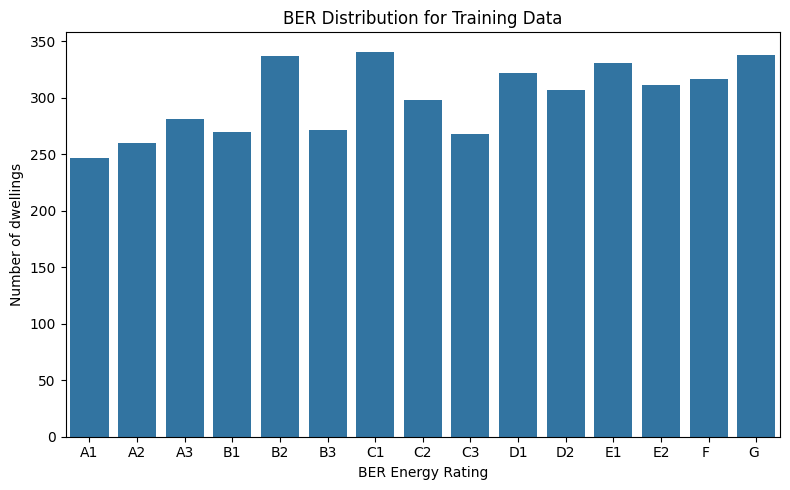

In [93]:
plt.figure(figsize=(8,5))
sns.countplot(
    data=df, 
    x='EnergyRating',
    order=sorted(df['EnergyRating'].unique())
)
plt.xlabel('BER Energy Rating')
plt.ylabel('Number of dwellings')
plt.title('BER Distribution for Training Data')
plt.tight_layout()
plt.show()


In [94]:
# Step 3 - Account for missing data 
numeric_cols = df.select_dtypes(include=np.number).columns.to_list()
columns_for_exclusion = ['CountyName', 'DwellingTypeDescr']
columns_for_inclusion = [col for col in numeric_cols if col not in columns_for_exclusion]
df_imputed = df.copy()

# Step 4 - Initialise the imputer, strategy for dealing with null values
imputer = SimpleImputer(strategy='median')

df_imputed[columns_for_inclusion] = imputer.fit_transform(df_imputed[columns_for_inclusion])

# Check these results 
print("Missing values after imputation")
print(df_imputed[columns_for_inclusion].isna().sum())
print(f"\nResults after imputation: {df_imputed.shape}")

# Step 5 - Create an initial list of features to use in clustering
list_features_clustering = [
    'Year_of_Construction', 
    'GroundFloorArea(sq m)', 
    'UValueWall',
    'UValueRoof', 
    'UValueFloor',
    'UValueWindow',
    'WaterStorageVolume',	
    'DeclaredLossFactor',
    'TempFactorMultiplier',
    'GroundFloorArea',
    'GroundFloorHeight',
    'FirstFloorHeight',
    'GlazingPercent',
    'Volume',

]


Missing values after imputation
Year_of_Construction         0
GroundFloorArea(sq m)        0
UValueWall                   0
UValueRoof                   0
UValueFloor                  0
UValueWindow                 0
UvalueDoor                   0
WallArea                     0
RoofArea                     0
FloorArea                    0
WindowArea                   0
DoorArea                     0
NoStoreys                    0
CO2Rating                    0
HSMainSystemEfficiency       0
TGDLEdition                  0
MPCDERValue                  0
HSEffAdjFactor               0
HSSupplHeatFraction          0
HSSupplSystemEff             0
WHMainSystemEff              0
WHEffAdjFactor               0
SupplSHFuel                  0
SupplWHFuel                  0
SHRenewableResources         0
WHRenewableResources         0
NoOfChimneys                 0
NoOfOpenFlues                0
NoOfFansAndVents             0
NoOfFluelessGasFires         0
FanPowerManuDeclaredValue    0
HeatExc

In [95]:

# Step 6 - Scaling the dataset
scaler = StandardScaler()
df_cluster = df_imputed[list_features_clustering].copy()
# X_scaled is a NumPy array (for scikit-learn models)
X_scaled = scaler.fit_transform(df_cluster)
# x-scaled-df is a dataframe with the same index / columns
X_scaled_df = pd.DataFrame(
    X_scaled,
    columns=df_cluster.columns,
    index=df_cluster.index
)
X_scaled_df.head()

,Year_of_Construction,GroundFloorArea(sq m),UValueWall,UValueRoof,UValueFloor,UValueWindow,WaterStorageVolume,DeclaredLossFactor,TempFactorMultiplier,GroundFloorArea,GroundFloorHeight,FirstFloorHeight,GlazingPercent,Volume
0,0.573655,-0.190648,-0.260178,-0.136941,0.182772,-0.671671,-0.343143,-0.218631,0.807761,-0.614988,-0.153130,0.787156,-0.465874,0.046483
1,0.964519,0.038120,-0.775275,-0.571344,-1.076295,-1.221667,3.149614,-0.218631,-0.843858,-0.316036,-0.191503,0.763935,-0.335610,0.216623
2,0.633788,0.168219,-0.760125,-0.540315,-0.198763,-1.221667,-0.533343,2.788346,-0.843858,-0.329903,-0.153130,0.794896,-0.241316,0.337368
3,-0.568871,0.470076,-0.593476,1.786847,0.640615,0.648321,-0.049198,-0.218631,0.807761,0.140792,0.077102,0.748454,-0.031901,0.579589
4,0.934452,0.813960,-0.684375,-0.540315,-0.961834,-0.561671,-0.135653,-0.218631,0.270985,2.230522,0.575940,-1.325951,-0.204572,-0.283535


In [96]:

# Classification Section - Internal validation on BER_Train 
# scaled features for BER_Train
X = X_scaled_df
y = df_imputed['EnergyRating']

# split for internal validation 
X_train, X_valuation, y_train, y_valuation = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Random Forest 
random_forest_model = RandomForestClassifier(
    n_estimators=200, 
    max_depth=None, 
    random_state=42, 
    n_jobs=1
)

random_forest_model.fit(X_train, y_train)
y_pred_random_forest_model_valuation = random_forest_model.predict(X_valuation)

print('Random Forest results(validation set):\n')
print(classification_report(y_valuation, y_pred_random_forest_model_valuation))

# k-NN
knn_classification = KNeighborsClassifier(
    n_neighbors=5, 
    weights='distance'
)
knn_classification.fit(X_train, y_train)
y_predict_knn_valuation = knn_classification.predict(X_valuation)

print('\nK-NN results (validation set)(k=5):\n')
print(classification_report(y_valuation, y_predict_knn_valuation))

Random Forest results(validation set):

              precision    recall  f1-score   support

          A1       0.64      0.74      0.69        50
          A2       0.68      0.77      0.72        52
          A3       0.81      0.54      0.65        56
          B1       0.49      0.46      0.48        54
          B2       0.36      0.46      0.41        67
          B3       0.28      0.22      0.25        54
          C1       0.28      0.35      0.31        68
          C2       0.19      0.17      0.18        60
          C3       0.27      0.22      0.24        54
          D1       0.27      0.34      0.30        65
          D2       0.15      0.11      0.13        61
          E1       0.25      0.24      0.25        66
          E2       0.26      0.19      0.22        62
          F        0.20      0.19      0.20        63
          G        0.51      0.65      0.57        68

    accuracy                           0.37       900
   macro avg       0.38      0.38      0

In [97]:
# Random Forest was better 
# Model training on actual BER
final_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None, 
    random_state=42, 
    n_jobs=-1
)
final_model.fit(X_scaled_df, df_imputed['EnergyRating'])

print('Final model trained on full BER_Train.csv')

Final model trained on full BER_Train.csv


In [105]:
# Read in Test dataset 
df_test = pd.read_csv('BER_Test.csv', encoding='utf-8')
df_test.head()

,CountyName,DwellingTypeDescr,Year_of_Construction,EnergyRating,GroundFloorArea(sq m),UValueWall,UValueRoof,UValueFloor,UValueWindow,UvalueDoor,...,WaterStorageVolume,DeclaredLossFactor,TempFactorUnadj,TempFactorMultiplier,GroundFloorArea,GroundFloorHeight,FirstFloorArea,FirstFloorHeight,GlazingPercent,Volume
0,Co. Wexford,Detached house,1951,E1,138.17,1.68,0.26,0.68,4.95,2.35,...,NaN,NaN,NaN,NaN,113.66,2.40,24.51,2.65,0.134907,697.7585
1,Co. Galway,Detached house,1993,B3,186.19,0.36,0.34,0.57,1.10,1.11,...,NaN,NaN,NaN,NaN,119.58,2.46,66.61,2.21,0.099566,869.5073
2,Co. Meath,Semi-detached house,2005,C1,116.50,0.37,0.26,0.34,2.30,3.00,...,117.0,0.0,0.6,1.3,58.25,2.44,58.25,2.90,0.165224,622.1100
3,Co. Galway,End of terrace house,2003,E2,98.92,0.55,0.20,0.41,3.10,3.00,...,194.0,0.0,0.6,1.0,49.46,2.50,49.46,2.87,0.075610,531.2004
4,Co. Wexford,Detached house,2022,A1,310.69,0.17,0.14,0.24,0.91,1.09,...,NaN,NaN,NaN,NaN,176.17,2.58,134.52,2.65,0.162269,1624.9087


In [110]:
# Apply preprocessing to TEST dataset
df_test_imputed = df_test.copy()
df_test_imputed[columns_for_inclusion] = imputer.transform(df_test[columns_for_inclusion])

df_test_cluster = df_test_imputed[list_features_clustering].copy()
X_test_scaled = scaler.transform(df_test_cluster)

X_test_scaled_df = pd.DataFrame(
    X_test_scaled, 
    columns=df_test_cluster.columns, 
    index=df_test_cluster.index
)

y_test_true = df_test_imputed['EnergyRating']

# Final predictions on BER Test set 
y_pred_test_final = final_model.predict(X_test_scaled_df)
print('\nFINAL Test set results using BER_TEST.csv\n')
print(classification_report(y_test_true, y_pred_test_final))


FINAL Test set results using BER_TEST.csv

              precision    recall  f1-score   support

          A1       0.55      0.76      0.64        21
          A2       0.82      0.69      0.75        26
          A3       0.60      0.58      0.59        26
          B1       0.39      0.31      0.35        35
          B2       0.38      0.53      0.44        34
          B3       0.33      0.22      0.26        32
          C1       0.38      0.54      0.45        35
          C2       0.30      0.24      0.27        37
          C3       0.27      0.27      0.27        30
          D1       0.27      0.36      0.31        33
          D2       0.19      0.19      0.19        37
          E1       0.03      0.03      0.03        35
          E2       0.33      0.13      0.18        47
          F        0.32      0.29      0.31        41
          G        0.56      0.78      0.65        32

    accuracy                           0.37       501
   macro avg       0.38      0.40   

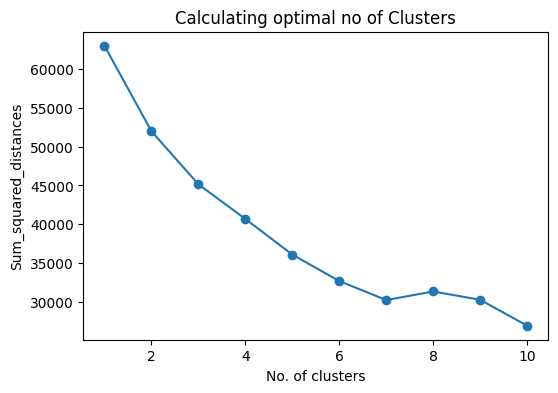

In [98]:
# Step 7 - Calculate optimal number of clusters using the Elbow Method

sum_squared_distance = []
K_range = range(1,11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    kmeans.fit(X_scaled)
    sum_squared_distance.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K_range, sum_squared_distance, marker='o')
plt.xlabel('No. of clusters')
plt.ylabel('Sum_squared_distances')
plt.title('Calculating optimal no of Clusters')
plt.show()

In [99]:

# 7 appeared to be the optimal number of clusters
# Step 8 - Applying KMeans Clustering
kmeans_fit = KMeans(n_clusters=7, random_state=42, n_init="auto")
kmeans_fit.fit(X_scaled)
df_cluster['cluster'] = kmeans_fit.labels_

In [100]:
# Creating a clean feature matrix and running PCA
# Use scaled matrix fom KMeans
X = X_scaled

# 2d PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

pca_df = pd.DataFrame(
    X_pca,
    columns=['PC1', 'PC2'],
)

# attach cluster labels directly from kmeans fit
pca_df['cluster'] = kmeans_fit.labels_

# attaching original energy rating 
pca_df['EnergyRating'] = df_imputed['EnergyRating'].values

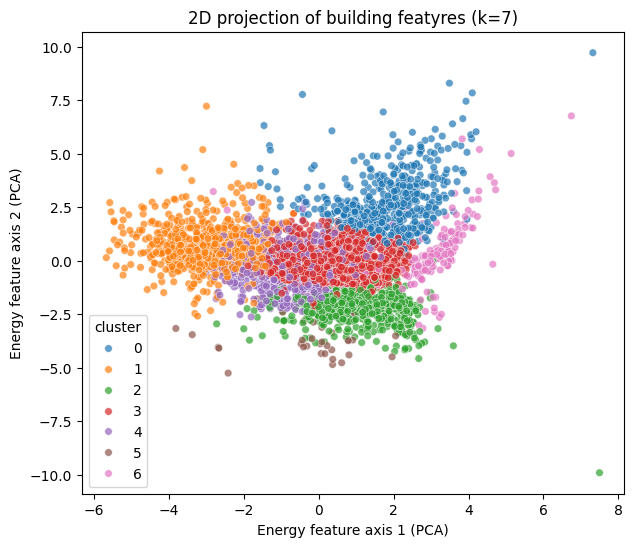

In [101]:
#Notes for write up, 
# PC1 and PC2 are the first principal components, e.g. new axis 
# that are linear combinations of the original features
plt.figure(figsize=(7,6))
sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue='cluster',
    palette='tab10',
    s=30,
    alpha=0.7
)
plt.title('2D projection of building featyres (k=7)')
plt.xlabel('Energy feature axis 1 (PCA)')
plt.ylabel('Energy feature axis 2 (PCA)')
plt.tight_layout
plt.show()


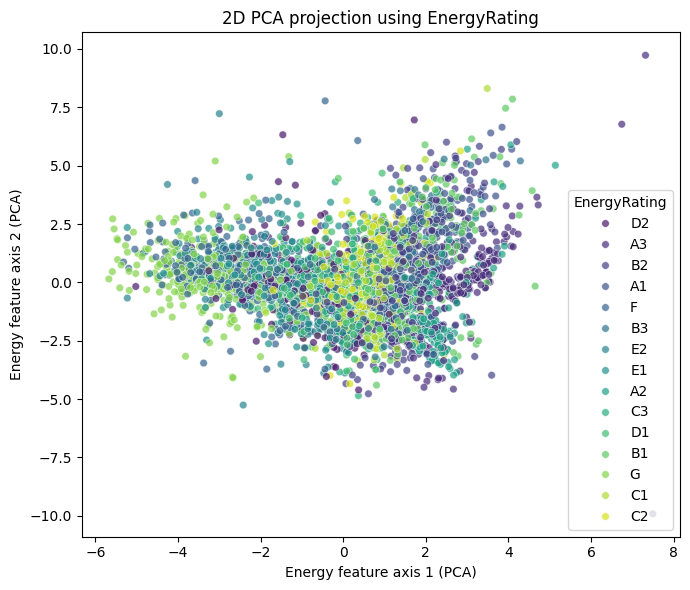

In [102]:
# 2d scatter plot coloured by Energy Rating
plt.figure(figsize=(7,6))
sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue='EnergyRating',
    palette='viridis',
    s=30, 
    alpha=0.7
)
plt.title('2D PCA projection using EnergyRating')
plt.xlabel('Energy feature axis 1 (PCA)')
plt.ylabel('Energy feature axis 2 (PCA)')
plt.tight_layout()
plt.show()



In [103]:
# Using Hierarchial clustering to analyse BER data

linkage_data = linkage(X_scaled, method='ward')

# Plotting the data using a dendrogram
plt.figure(figsize=(10,6))
dendrogram(linkage_data)
plt.title('Hierarchial Clustering using BER data')
plt.xlabel('Sample Index')
plt.ylabel('Distance (ward)')
plt.show()
# cut the dendrogram to get 7 clusters
hierarchial_cluster_assignments = fcluster(linkage_data, t=7, criterion='maxclust')

# note fcluster returns labels starting from 1, not 0
# converting to 0-indexed to match KMeans 
hierarchial_cluster_assignments = hierarchial_cluster_assignments - 1

KeyboardInterrupt: 

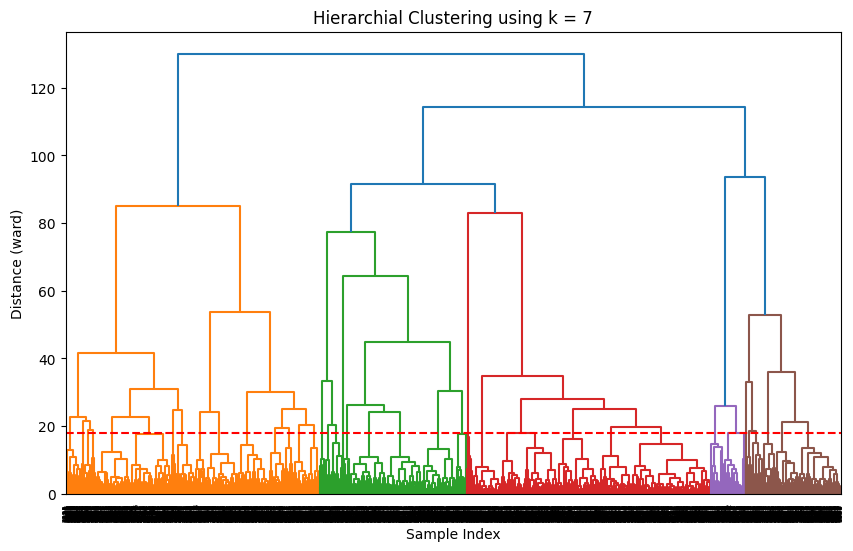

In [ ]:
# Plotting the dendrogram using k = 7 for clustering
plt.figure(figsize=(10,6))
dendrogram(linkage_data, truncate_mode='lastp', p=30)
plt.title('Hierarchial Clustering using k = 7')
plt.xlabel('Sample Index')
plt.ylabel('Distance (ward)')
plt.axhline(y=18, color='r', linestyle='--', label='Cut for clustering k = 7')
plt.show()

In [ ]:

# Comparing KMeans and Clustering Comparison using Silhouette Scoring and Davies Bouldin Score

kmeans_labels = df_cluster['cluster']

silhouette_scoring_kmeans = silhouette_score(X_scaled, kmeans_labels)
davies_bouldin_scoring_kmeans = davies_bouldin_score(X_scaled, kmeans_labels)
silhouette_scoring = silhouette_score(X_scaled, hierarchial_cluster_assignments)
davies_bouldin_scoring = davies_bouldin_score(X_scaled, hierarchial_cluster_assignments)
print(f"\nKmeans scoring: ")

print(f"Silhouette scoring (KMeans): {silhouette_scoring_kmeans:.2f}")
print(f"Davies-Bouldin scoring (KMeans): {davies_bouldin_scoring_kmeans:.2f}")
print(f"Hierarchial scoring: ")

print(f"silhouette scoring (hierarchial): {silhouette_scoring:.2f}")
print(f"Davies-Bouldin scoring (hierarchial): {davies_bouldin_scoring:.2f}")


Kmeans scoring: 
Silhouette scoring (KMeans): 0.25
Davies-Bouldin scoring (KMeans): 1.23
Hierarchial scoring: 
silhouette scoring (hierarchial): 0.22
Davies-Bouldin scoring (hierarchial): 1.34
